# Learning to Control Burgers Equation with Differentiable Physics
This notebook will walk you through data generation, supervised network initialization and end-to-end training using our differentiable PDE solver, [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

The code below replicates experiment 1 from the ICLR 2020 paper [Learning to Control PDEs with Differentiable Physics](https://ge.in.tum.de/publications/2020-iclr-holl/). The original experiment was performed on an older version of the solver. The corresponding code can be found under `/legacy` but is more difficult to understand and not as well documented.

In [ ]:
import sys; sys.path.append('../PhiFlow'); sys.path.append('../src')
from control.pde.burgers import GaussianClash, GaussianForce
import burgers_plots as bplt
import matplotlib.pyplot as plt
from phi.flow import *

## Data Generation

In [ ]:
domain = Domain([128], box=box[0:1])  # 1D Grid resolution and physical size
viscosity = 0.003  # Viscosity constant for Burgers equation
step_count = 32  # how many solver steps to perform
dt = 0.03  # Time increment per solver step

Let's have a look at an example Burgers simulation with Gaussian forcing. The classes `BurgersVelocity` and `Burgers` are part of the Φ<sub>Flow</sub> library.

*Hint: You can execute the cell below multiple times to get different results. Both `GaussianClash` and `GaussianForce` use random numbers internally.*

Force: -0.417051 at 0.533093


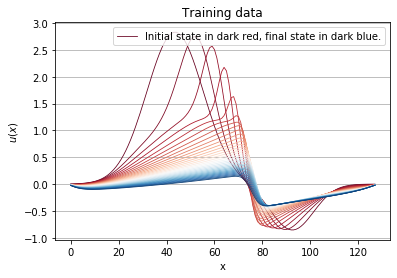

In [14]:
# --- Set up physics ---
world = World()
u0 = BurgersVelocity(domain, velocity=GaussianClash(1), viscosity=viscosity)
u = world.add(u0, physics=Burgers(diffusion_substeps=4))
force = world.add(FieldEffect(GaussianForce(1), ['velocity']))
# --- Plot ---
print('Force: %f at %f' % (force.field.amp[0], force.field.loc[0]))
bplt.burgers_figure('Training data')
plt.plot(u.velocity.data[0,:,0], color=bplt.gradient_color(0, step_count+1), linewidth=0.8)  # data[example, values, component]
plt.legend(['Initial state in dark red, final state in dark blue.'])
for frame in range(1, step_count + 1):
    world.step(dt=dt)  # runs one simulation step
    plt.plot(u.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

Next, we define how many examples to generate and where to store them.

In [ ]:
data_path = '~/phi/data/control/forced-burgers-clash'
scene_count = 1000  # how many examples to generate (training + validation + test)
batch_size = 100  # How many examples to generate in parallel

The following cell will generate and store the data.

In [ ]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(domain, velocity=GaussianClash(batch_size), viscosity=viscosity, batch_size=batch_size, name='burgers')
    u = world.add(u0, physics=Burgers(diffusion_substeps=4))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

To delete the generated data, uncomment and run the cell below.

In [ ]:
#for scene in Scene.list(data_path): scene.remove()

# Supervised Initialization

We can use a supervised observation loss to initialize the observation prediction (OP) networks.
This teaches them to reproduce the simulations from the training data.

In [4]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence

Define what part of the data is used for training, validation and testing.

In [5]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains all OP$_n \,\, \forall n\in\{2,4,8,16,32\}$.
The `ControlTraining` class is used to set up the optimization problem.

The loss for the supervised initialization is defined as the observation loss at the center frame.

$\boldsymbol L_o^\textrm{sup} = \left|\mathrm{OP}[o(t_i),o(t_j)] - u^\textrm{GT}\left(\frac{t_i+t_j}{2}\right)\right|^2.$

Consequently, no sequence needs to be simulated (`sequence_class=None`) and an observation loss is required at frame $\frac n 2$ (`obs_loss_frames=[n // 2]`).
The pretrained network checkpoints are stored in `checkpoint_dict`.

*Note: The next cell will run for some time. You can skip it and load the pretrained networks instead (see instructions below).*

In [ ]:
import tensorflow as tf; tf.reset_default_graph()

checkpoint_dict = {}

for n in [2, 4, 8, 16, 32]:
    app = ControlTraining(n,
                          BurgersPDE(domain, viscosity, dt),
                          datapath=data_path,
                          val_range=val_range,
                          train_range=train_range,
                          trace_to_channel=lambda trace: 'burgers_velocity',
                          obs_loss_frames=[n // 2],
                          trainable_networks=['OP%d' % n],
                          sequence_class=None,
                          batch_size=100,
                          view_size=20,
                          learning_rate=1e-3,
                          learning_rate_half_life=1000,
                          dt=dt).prepare()
    # show(app)  # launches the Φ-Flow web interface
    for i in range(3000):
        app.progress()  # Run Optimization for one batch
    checkpoint_dict['OP%d' % n] = app.save_model()

In [ ]:
checkpoint_dict

If you have already initialized the networks, you can simply copy the `checkpoint_dict` by pasting the output above into the cell below.

In [ ]:
#checkpoint_dict = 

Or load the pretrained networks that are included in the repository by uncommenting and running the cell below.

In [20]:
#checkpoint_dict = {'OP%d'%n: '../networks/burgers/supervised/OP%d_3000'%n for n in [2,4,8,16,32]}

Note that we have not actually set up a simulation for the training. To evaluate the quality of our current solutions, we will use the `ControlTraining` class again but this time passing a `sequence_class`.
With a sequence class, `ControlTraining` sets up the necessary physics steps and networks.
Example sequence classes are `StaggeredSequence` and `RefinedSequence`.

In [6]:
step_count = 32

In [ ]:
import tensorflow as tf; tf.reset_default_graph()

staggered_app = ControlTraining(step_count,
                      BurgersPDE(domain, viscosity, dt),
                      datapath=data_path,
                      val_range=val_range,
                      train_range=train_range,
                      trace_to_channel=lambda trace: 'burgers_velocity',
                      obs_loss_frames=[],
                      trainable_networks=['OP%d' % n for n in [2,4,8,16,32]],
                      sequence_class=StaggeredSequence,
                      batch_size=100,
                      view_size=20,
                      learning_rate=1e-3,
                      learning_rate_half_life=1000,
                      dt=dt).prepare()
staggered_app.load_checkpoints(checkpoint_dict)

We can have a look at the force required to exactly match the target in our test set.

*Note:* The property `'Total Force'` is created by `BurgersPDE`.

In [23]:
print('Total Force (supervised): %f' % staggered_app.infer_scalars(test_range)['Total Force'])

Total Force (supervised): 100.640335


Let's have a look at some of the reconstructed sequences. Change the `test_range` indices to look at different examples.

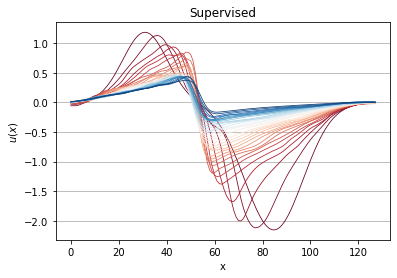

In [24]:
states = staggered_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Supervised')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

# End-to-end Training with Differentiable Physics

To evaluate the supervised initialization, we have already set up all the physics we need to train the networks end-to-end.

The following cell trains all OP networks jointly to minimize the force. You can increase the number of optimization steps or execute the next cell multiple times to further increase performance.

*Note: The next cell will run for some time. You can skip the next two cells and load the pretrained networks instead.*

In [ ]:
for i in range(1000):
    staggered_app.progress()

In [ ]:
diffphys_checkpoint = staggered_app.save_model()
diffphys_checkpoint

To load the pretrained networks included in this repository, uncomment and execute the cell below.

In [ ]:
#staggered_app.load_checkpoints({'OP%d'%n: '../networks/burgers/staggered/OPn_1000' for n in [2,4,8,16,32]})

Let's evaluate the performance of our networks after end-to-end training.

Total Force (diff. phys. / staggered): 66.463921


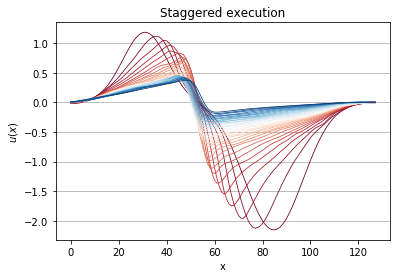

In [10]:
print('Total Force (diff. phys. / staggered): %f' % staggered_app.infer_scalars(test_range)['Total Force'])
states = staggered_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Staggered execution')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)

To evaluate our models using the prediction refinement scheme, we repeat the above steps but using a `RefinedSequence` instead of a `StaggeredSequence`.

In [ ]:
import tensorflow as tf; tf.reset_default_graph()


refined_app = ControlTraining(step_count,
                      BurgersPDE(domain, viscosity, dt),
                      datapath=data_path,
                      val_range=val_range,
                      train_range=train_range,
                      trace_to_channel=lambda trace: 'burgers_velocity',
                      obs_loss_frames=[],
                      trainable_networks=['OP%d' % n for n in [2,4,8,16,32]],
                      sequence_class=RefinedSequence,
                      batch_size=100,
                      view_size=20,
                      learning_rate=1e-3,
                      learning_rate_half_life=1000,
                      dt=dt).prepare()

To load the weights we just trained, run the cell below.

To load the pretrained weights, skip the next cell and uncomment and run the one after that.

In [ ]:
refined_app.load_checkpoints({'OP%d' % n: diffphys_checkpoint for n in [2,4,8,16,32]})

In [ ]:
#refined_app.load_checkpoints({'OP%d'%n: '../networks/burgers/staggered/OPn_1000' for n in [2,4,8,16,32]})

We could still refine training at this point by repeatedly calling `refined_app.progress()`.
Here, we show that the prediction refinement scheme beats the staggered execution, despite not being trained with that architecture.

Total Force (diff. phys. / refined): 64.307983


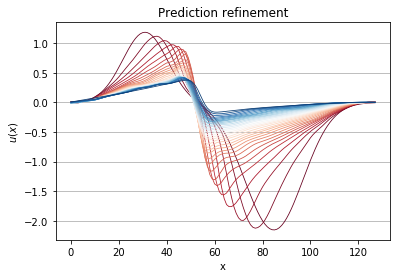

In [13]:
print('Total Force (diff. phys. / refined): %f' % refined_app.infer_scalars(test_range)['Total Force'])
states = refined_app.infer_all_frames(test_range[0:1])
bplt.burgers_figure('Prediction refinement')
for frame in range(0, step_count + 1):
    plt.plot(states[frame].burgers.velocity.data[0,:,0], color=bplt.gradient_color(frame, step_count+1), linewidth=0.8)